# Analysis of YouTube Content Creation Evolution

This notebook explores the frequency and consistency of content creation across different YouTube channel categories over time, using the YouNiverse dataset.

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle

In [ ]:
# Load the datasets
channel_data = pd.read_csv("data/df_channels_en_with_monetization.csv", dtype={
        'has_affiliate': 'boolean',
        'has_sponsorships': 'boolean',
        'has_merchandise': 'boolean'
    })

timeseries_data = pd.read_csv("data/df_timeseries_en.tsv.gz", compression="infer", sep="\t")
video_data = pd.read_feather("data/yt_metadata_helper.feather")

In [17]:
channel_data.head(5)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,has_affiliate,has_sponsorships,has_merchandise
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087,9800.0,156700.0,117600.0,1900000.00,<NA>,<NA>,<NA>
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087,NaN,NaN,NaN,NaN,False,False,True
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087,0.0,0.0,0.0,0.05,False,False,False
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087,178700.0,2900000.0,2100000.0,34300000.00,False,False,False


In [18]:
timeseries_data.head(5)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03 00:00:00,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10 00:00:00,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17 00:00:00,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24 00:00:00,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31 00:00:00,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0


In [19]:
video_data.head(5)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,SBqSc91Hn9g,1159,8.0,2016-09-28,1057.0
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,UuugEl86ESY,2681,23.0,2016-09-28,12894.0
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,779.0,oB4c-yvnbjs,1394,1607.0,2016-09-28,1800602.0
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,24.0,ZaV-gTCMV8E,5064,227.0,2016-09-28,57640.0
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,13.0,cGvL7AvMfM0,3554,105.0,2016-09-28,86368.0


In [20]:
channel_data['join_date'] = pd.to_datetime(channel_data['join_date'])
video_data['upload_date'] = pd.to_datetime(video_data['upload_date'])
timeseries_data['datetime'] = pd.to_datetime(timeseries_data['datetime'])

In [21]:
channel_data.isna().sum()

category_cc                    128
join_date                        1
channel                          0
name_cc                         10
subscribers_cc                   0
videos_cc                        0
subscriber_rank_sb               0
weights                          0
lowest_monthly_earnings     136175
highest_monthly_earnings    136175
lowest_yearly_earnings      136175
highest_yearly_earnings     136175
has_affiliate               101062
has_sponsorships            101062
has_merchandise             101062
dtype: int64

We might want to remove samples that have NaN category and/or NaN name.

In [22]:
channel_data.shape

(136470, 15)

In [23]:
# Remove samples that have no category and/or name
channel_data = channel_data.dropna(subset=['category_cc', 'name_cc'])

In [24]:
# New shape after removing samples
channel_data.shape

(136332, 15)

In [27]:
timeseries_data.isna().sum()

channel             0
category        20584
datetime            0
views               0
delta_views         0
subs                0
delta_subs          0
videos              0
delta_videos        0
activity            0
dtype: int64

In [28]:
timeseries_data.shape

(18872499, 10)

In [30]:
timeseries_data = timeseries_data.dropna()

In [ ]:
# New shape after removing samples
timeseries_data.shape

(18851915, 10)

In [25]:
video_data.isna().sum()

categories             0
channel_id             0
dislike_count    1631458
display_id             0
duration               0
like_count       1631458
upload_date            0
view_count           654
dtype: int64

The fact that there are some NaN values about the dislike, like and view counts won't affect our research about the frequency and consistency of content creation, so we can keep all the data of the video metadata.

In [26]:
video_data.shape

(72924794, 8)

In [32]:
# Add year and month columns of upload date of the video data to facilitate time-based analysis
video_data['year'] = video_data['upload_date'].dt.year
video_data['month'] = video_data['upload_date'].dt.to_period('M')

In [35]:
# Merge with channel metadata if needed
channel_video_data = video_data.merge(
    channel_data,
    left_on='channel_id', # Column name in video data
    right_on='channel',   # Column name in channel data
    how='inner'
)

In [40]:
channel_video_data = channel_video_data.drop(columns='channel')

In [41]:
channel_video_data = channel_video_data.rename(
    columns={
        'categories': 'video_category',
        'category_cc': 'channel_category'
    }
)

In [42]:
channel_video_data.columns

Index(['video_category', 'channel_id', 'dislike_count', 'display_id',
       'duration', 'like_count', 'upload_date', 'view_count', 'year', 'month',
       'channel_category', 'join_date', 'name_cc', 'subscribers_cc',
       'videos_cc', 'subscriber_rank_sb', 'weights', 'lowest_monthly_earnings',
       'highest_monthly_earnings', 'lowest_yearly_earnings',
       'highest_yearly_earnings', 'has_affiliate', 'has_sponsorships',
       'has_merchandise'],
      dtype='object')

In [43]:
channel_video_data.head(5)

,video_category,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,year,month,...,videos_cc,subscriber_rank_sb,weights,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,has_affiliate,has_sponsorships,has_merchandise
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,SBqSc91Hn9g,1159,8.0,2016-09-28,1057.0,2016,2016-09,...,2398,54617.0,3.5155,NaN,NaN,NaN,NaN,False,False,False
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,UuugEl86ESY,2681,23.0,2016-09-28,12894.0,2016,2016-09,...,2398,54617.0,3.5155,NaN,NaN,NaN,NaN,False,False,False
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,779.0,oB4c-yvnbjs,1394,1607.0,2016-09-28,1800602.0,2016,2016-09,...,2398,54617.0,3.5155,NaN,NaN,NaN,NaN,False,False,False
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,24.0,ZaV-gTCMV8E,5064,227.0,2016-09-28,57640.0,2016,2016-09,...,2398,54617.0,3.5155,NaN,NaN,NaN,NaN,False,False,False
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,13.0,cGvL7AvMfM0,3554,105.0,2016-09-28,86368.0,2016,2016-09,...,2398,54617.0,3.5155,NaN,NaN,NaN,NaN,False,False,False


In [44]:
channel_video_data.shape

(72882785, 24)

In [48]:
# Identify rows where channel_category is different from video_category
mismatched_categories = channel_video_data[channel_video_data['channel_category'] != channel_video_data['video_category']]

# Count the mismatched samples
num_mismatched = mismatched_categories.shape[0]

print(f"Number of samples with mismatched categories: {num_mismatched}")

# Percentage of mismatched samples
percentage_mismatched = (num_mismatched / channel_video_data.shape[0]) * 100

print(f"Percentage of samples with mismatched categories: {percentage_mismatched:.2f}%")

Number of samples with mismatched categories: 13341605
Percentage of samples with mismatched categories: 18.31%


Since some channels assigned as a certain category create videos of another category (18.31%) as the one they are assigned, it might be good to make a frequency and consistency analysis with respect to the channels and another analysis with respect to the video categories.

## Step 1: Channels Analysis

### Frequency Analysis

We define frequency as the number of uploads made by channels within a given category over a specific time period (e.g., per year, per month). It provides a measure of how often content is being uploaded for each category.

We care about frequency because it shows how active channels in each category are over time and it helps identify which categories are growing or declining in activity. In our case, higher frequencies may indicate more professionalized or competitive categories.


In [71]:
# Calculate the number of uploads per category per year
frequency_analysis = channel_video_data.groupby(['channel_category', 'year', 'month']).size().reset_index(name='upload_count')

print(frequency_analysis.head())

   channel_category  year    month  upload_count
0  Autos & Vehicles  2005  2005-12             1
1  Autos & Vehicles  2006  2006-01             4
2  Autos & Vehicles  2006  2006-02           117
3  Autos & Vehicles  2006  2006-03            29
4  Autos & Vehicles  2006  2006-04            21


#### Yearly Growth per Category

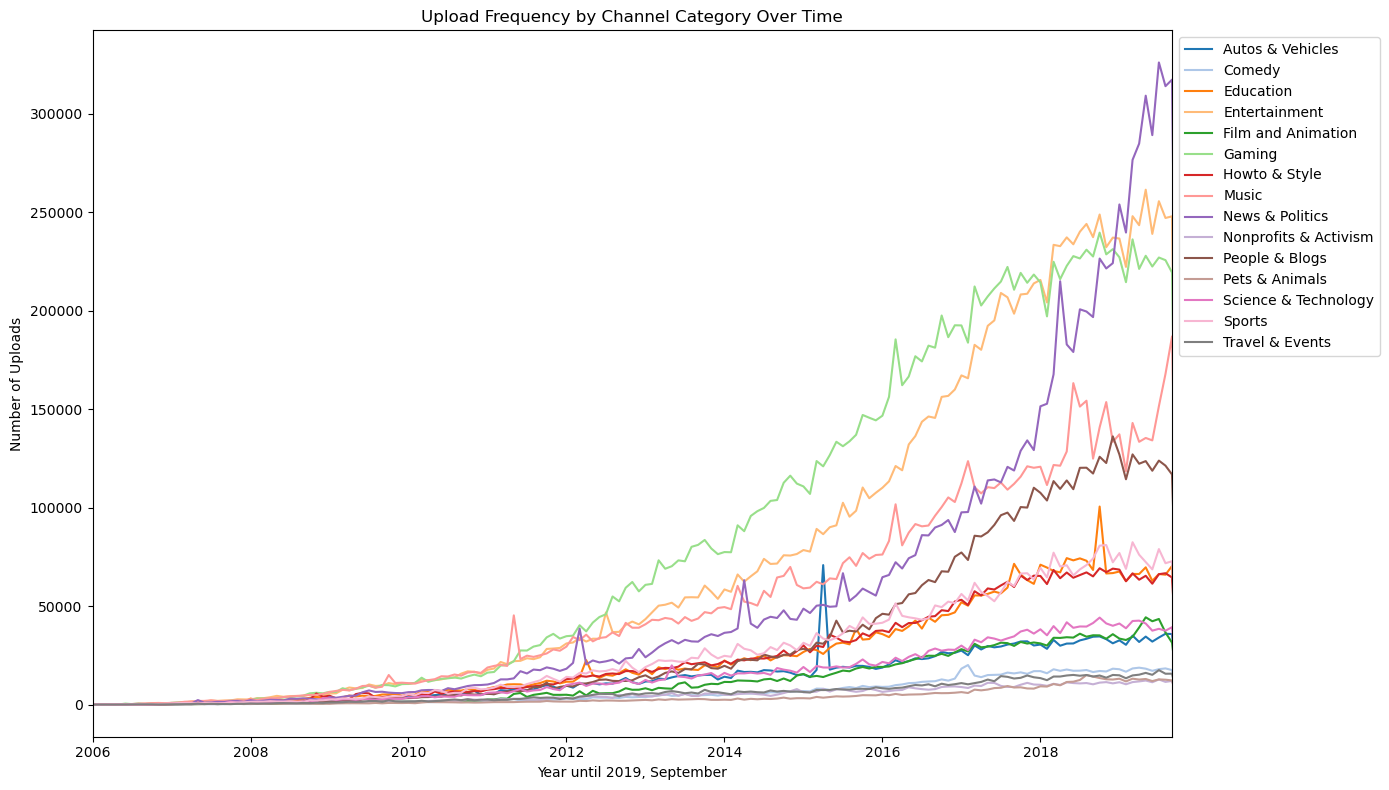

In [135]:
temp_df = frequency_analysis.copy()

temp_df['month'] = frequency_analysis['month'].dt.month
temp_df['time'] = frequency_analysis['year'] + (temp_df['month'] - 1) / 12

# We stop at year 2019, month September because there are almost no data to plot after this date
cutoff_year = 2019 + (9 - 1) / 12

# Define a color cycle with 15 distinct colors
colors = plt.cm.tab20.colors  # Tab20 provides 20 distinct colors
color_cycle = cycle(colors)  # Cycle through the colors

# Plot upload frequencies over time
plt.figure(figsize=(14, 8))
categories = temp_df['channel_category'].unique()

for category in categories:
    subset = temp_df[temp_df['channel_category'] == category]
    plt.plot(subset['time'], subset['upload_count'], label=category, color=next(color_cycle))

# Customize the plot
plt.title("Upload Frequency by Channel Category Over Time")
plt.xlabel("Year until 2019, September")
plt.ylabel("Number of Uploads")
plt.xlim(2006, cutoff_year)  # Limit the x-axis to the range [2006, 2019.91]
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.tight_layout()
plt.show()


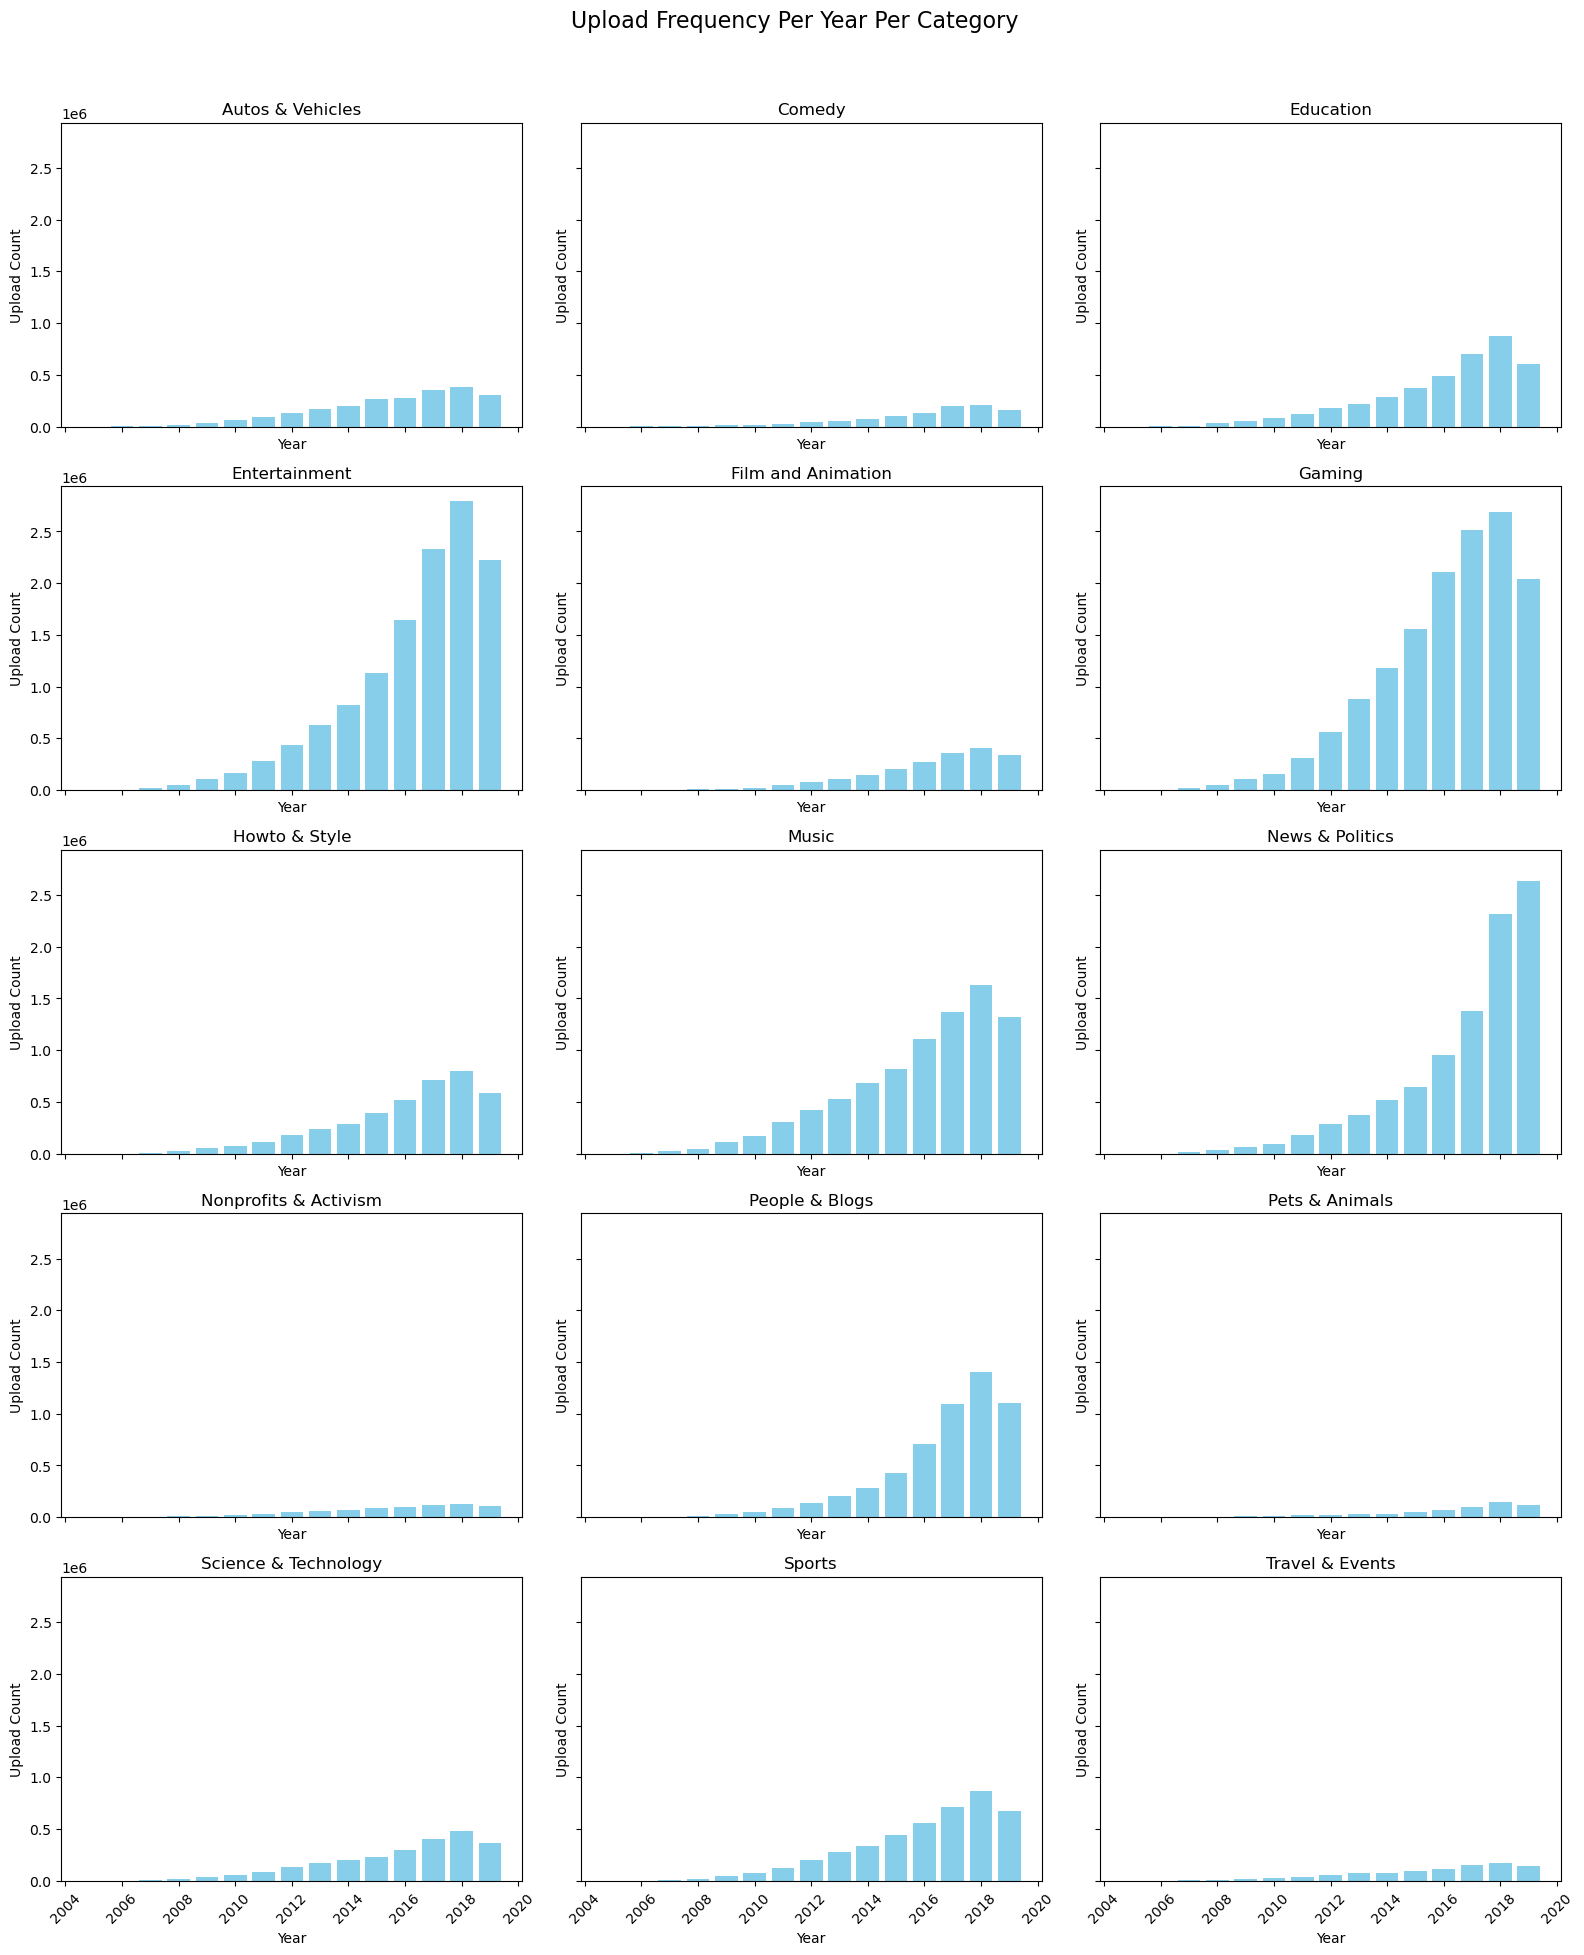

In [ ]:
# Group by channel category and year to calculate upload frequency
yearly_frequency = frequency_analysis.groupby(['channel_category', 'year']).agg({'upload_count': 'sum'}).reset_index()

# Get the unique categories
categories = yearly_frequency['channel_category'].unique()

# Number of subplots
n_categories = len(categories)
n_cols = 3
n_rows = 5

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each category in a separate subplot
for i, category in enumerate(categories):
    # Filter data for the category
    category_data = yearly_frequency[yearly_frequency['channel_category'] == category]
    axes[i].bar(category_data['year'], category_data['upload_count'], color='skyblue')
    
    # Customize the subplot
    axes[i].set_title(category)
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Upload Count")
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.suptitle("Upload Frequency Per Year Per Category", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The categories that witnessed the biggest upload growth over the years are: Music, News & Politics, Gaming, Entertainment and People & Blog. Their growth might indicate a professionalization that could be correlated with the consistency analysis.

#### Upload Frequency per Channel

In [83]:
# Count uploads per channel
channel_uploads = channel_video_data.groupby(['channel_id', 'channel_category']).size().reset_index(name='upload_count')

# Compute average uploads per channel for each category
average_uploads_per_category = channel_uploads.groupby('channel_category')['upload_count'].mean().reset_index(name='avg_uploads_per_channel')

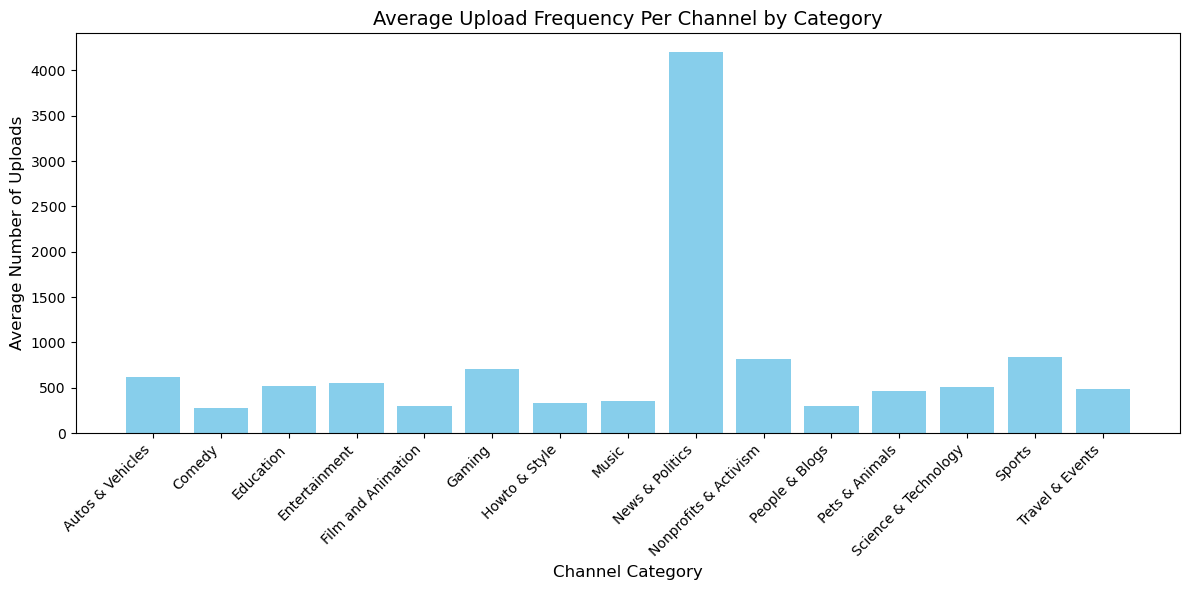

In [84]:
plt.figure(figsize=(12, 6))
plt.bar(average_uploads_per_category['channel_category'], average_uploads_per_category['avg_uploads_per_channel'], color='skyblue')

# Customize the plot
plt.title("Average Upload Frequency Per Channel by Category", fontsize=14)
plt.xlabel("Channel Category", fontsize=12)
plt.ylabel("Average Number of Uploads", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate category names for better readability
plt.tight_layout()

# Show the plot
plt.show()

The category 'News & Politics' exhibits the highest average upload frequency per channel by far. The possible reason for this could be due to the fact that news are time-sensitive content: updates need to be uploaded frequently to stay relevant.

The categories 'Gaming' and 'Sports' also exhibit relatively high upload frequencies.

Analyzing engagement metrics (views, likes, dislikes) would help understand if high upload frequency correlates with better audience engagement for these categories.

#### Relationship with Engagement

We will try to analyse if the frequency of uploads have a relationship with any engagement metrics such as subscribers count, views count, likes count and dislikes count.

##### Channels Engagement

We analyse in this part if engagement metrics with respect to channels have some correlation with upload frequency.

In [166]:
# Aggregate upload frequency, engagement metrics, and additional channel data
channel_engagement = channel_video_data.groupby('channel_id').agg({
    'upload_date': 'count',        # Total uploads (frequency)
    'view_count': 'sum',           # Total views per channel
    'like_count': 'sum',           # Total likes per channel
    'dislike_count': 'sum',        # Total dislikes per channel
    'subscribers_cc': 'first',     # Number of subscribers (assuming it's constant for a channel)
}).reset_index()

# Rename columns for clarity
channel_engagement.rename(columns={
    'upload_date': 'upload_frequency',
    'view_count': 'total_views_per_channel',
    'like_count': 'total_likes_per_channel',
    'dislike_count': 'total_dislikes_per_channel',
    'subscribers_cc': 'subscribers',
}, inplace=True)

print(channel_engagement.head())

                 channel_id  upload_frequency  total_views_per_channel  \
0  UC--24Q3_ZQeFmgJE-Um5QZQ               189                3291383.0   
1  UC--2EbuIuBOGgGqPiJxi3rg                60                7999515.0   
2  UC--3c8RqSfAqYBdDjIG3UNA               333               63626751.0   
3  UC--3ozenTzry39-xMqAPQlw                43                5192527.0   
4  UC--6E6EpybocdaNlPhvK_9A                31                9317278.0   

   total_likes_per_channel  total_dislikes_per_channel  subscribers  
0                  64823.0                      1544.0        17308  
1                  38553.0                      2383.0        13869  
2                 323791.0                     20737.0        73523  
3                  35760.0                       952.0       108000  
4                 226691.0                      6142.0        93900  


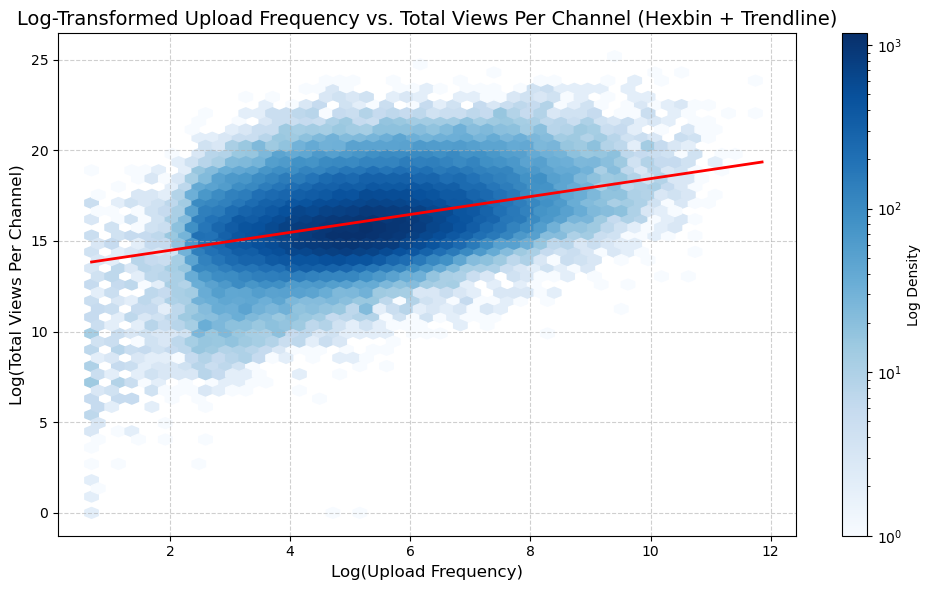

In [167]:
# Log-transform upload frequency and view count
channel_engagement['log_upload_frequency'] = np.log1p(channel_engagement['upload_frequency'])
channel_engagement['log_view_count'] = np.log1p(channel_engagement['total_views_per_channel'])

# Create the hexbin plot
plt.figure(figsize=(10, 6))
plt.hexbin(
    x=channel_engagement['log_upload_frequency'], 
    y=channel_engagement['log_view_count'], 
    gridsize=50, 
    cmap='Blues', 
    bins='log'
)

# Add the regression line
sns.regplot(
    x='log_upload_frequency',
    y='log_view_count',
    data=channel_engagement,
    scatter=False,
    color='red',
    line_kws={"lw": 2}
)

# Customize the plot
plt.colorbar(label='Log Density')
plt.title("Log-Transformed Upload Frequency vs. Total Views Per Channel (Hexbin + Trendline)", fontsize=14)
plt.xlabel("Log(Upload Frequency)", fontsize=12)
plt.ylabel("Log(Total Views Per Channel)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The red trendline indicates a positive relationship between the log-transformed upload frequency and log-transformed total views per channel. Channels that upload more frequently tend to accumulate more total views, suggesting that higher activity can lead to greater visibility and engagement over time.

The relationship is not perfectly linear (as indicated by the spread), meaning other factors, such as video quality or channel size, also influence total views.

The dark blue hexagons show that the majority of channels fall within the lower range of upload frequency (log ~2–6) and total views (log ~10–15). Most channels upload infrequently but still achieve moderate total views, possibly reflecting part-time or casual content creators.

As the upload frequency increases (log > 6), the density decreases, but total views tend to remain high. This could indicate that only a small proportion of channels maintain a high upload frequency, and these channels are often professional creators or part of high-demand categories (e.g., Gaming or News).

In [168]:
# Display the correlation matrix as a styled DataFrame
correlation_channel = channel_engagement[['upload_frequency', 'total_views_per_channel', 'total_likes_per_channel', 'total_dislikes_per_channel', 'subscribers']].corr()

print("Correlation Matrix:")
correlation_channel.round(2).style.background_gradient(cmap='coolwarm').format("{:.2f}")

Correlation Matrix:


,upload_frequency,total_views_per_channel,total_likes_per_channel,total_dislikes_per_channel,subscribers
upload_frequency,1.00,0.18,0.14,0.16,0.14
total_views_per_channel,0.18,1.00,0.69,0.82,0.79
total_likes_per_channel,0.14,0.69,1.00,0.64,0.75
total_dislikes_per_channel,0.16,0.82,0.64,1.00,0.73
subscribers,0.14,0.79,0.75,0.73,1.00


For channels, we see that upload frequency has little correlation with any of the engagement metrics. There are slight positive correlation between upload frequency and views, likes, dislikes and subscribers per channel.

These small correlations might be explained by the diversity between channels. For example, we could have some channels that got very high total views with just a few uploads while other channels got decent total views with a very high amount of uploads.

That is why we will analyse these same engagements metrics but with respect to the category of the channels. Moreover, later in the notebook, we will analyse the distribution of the upload frequency of channels to see if most views from a category come from a handful number of channels in this same category.

##### Categories Engagement

We analyse in this part if engagement metrics with respect to categories have some correlation with upload frequency.

In [180]:
# Deduplicate the channel-level data to avoid double-counting subscribers and videos
unique_channel_data = channel_video_data[['channel_id', 'channel_category', 'subscribers_cc']].drop_duplicates(subset='channel_id')

# Aggregate engagement metrics and additional data per category
category_engagement = channel_video_data.groupby('channel_category').agg({
    'upload_date': 'count',        # Total uploads per category
    'view_count': 'sum',           # Total views per category
    'like_count': 'sum',           # Total likes per category
    'dislike_count': 'sum'         # Total dislikes per category
}).reset_index()

# Aggregate unique channel-level metrics (subscribers, videos) per category
unique_channel_aggregation = unique_channel_data.groupby('channel_category').agg({
    'subscribers_cc': 'sum',        # Total unique subscribers per category
}).reset_index()

# Merge the two aggregations
category_engagement = pd.merge(category_engagement, unique_channel_aggregation, on='channel_category')

# Rename columns for clarity
category_engagement.rename(columns={
    'upload_date': 'total_uploads',
    'view_count': 'total_views',
    'like_count': 'total_likes',
    'dislike_count': 'total_dislikes',
    'subscribers_cc': 'total_subscribers',
}, inplace=True)

print(category_engagement)

         channel_category  total_uploads   total_views   total_likes  \
0        Autos & Vehicles        2294117  1.198044e+11  9.449940e+08   
1                  Comedy        1031074  3.292625e+11  5.901085e+09   
2               Education        4027635  5.256617e+11  3.028110e+09   
3           Entertainment       12628369  2.373897e+12  2.114761e+10   
4      Film and Animation        2018691  5.327963e+11  3.374969e+09   
5                  Gaming       14168267  1.074955e+12  1.779855e+10   
6           Howto & Style        3963876  4.040838e+11  5.623876e+09   
7                   Music        8522949  2.484319e+12  1.914191e+10   
8         News & Politics        9503610  1.728443e+11  2.049961e+09   
9   Nonprofits & Activism         791890  2.015861e+10  2.367161e+08   
10         People & Blogs        5553837  5.222211e+11  8.370012e+09   
11         Pets & Animals         602514  6.856796e+10  6.212901e+08   
12   Science & Technology        2466984  1.748264e+11  1.937676

In [177]:
print(category_engagement['total_subscribers'].describe())

count    1.500000e+01
mean     2.242692e+09
std      2.454805e+09
min      9.171362e+07
25%      5.393439e+08
50%      1.569171e+09
75%      2.819066e+09
max      8.064256e+09
Name: total_subscribers, dtype: float64


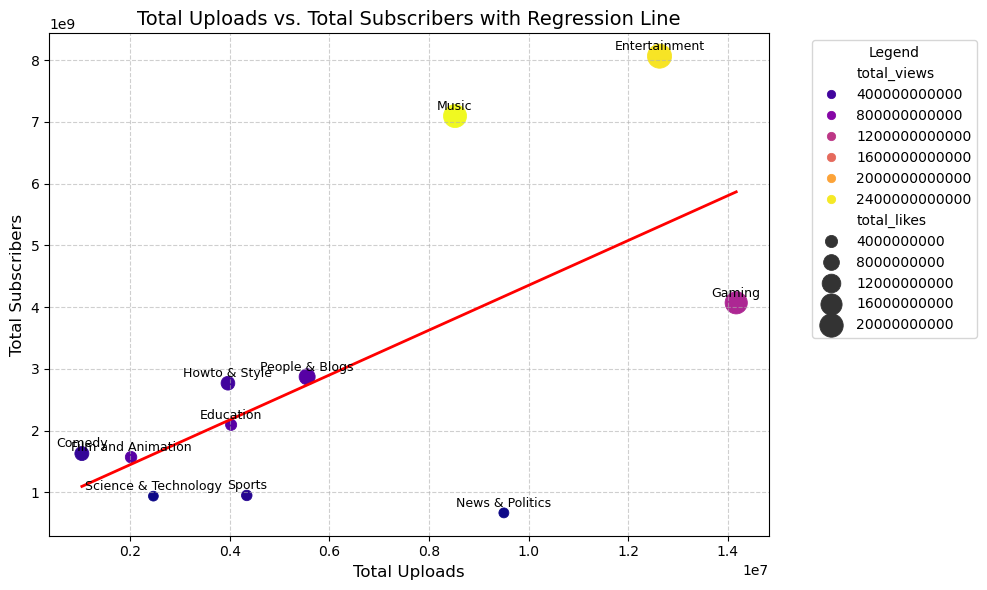

In [178]:
# Set the threshold to the 25th percentile to remove from the plots the categories with
# fewer subscribers that overlap too much for readability in the scatter plot
threshold = 5.39e8  # 539 million subscribers
filtered_category_engagement = category_engagement[category_engagement['total_subscribers'] > threshold]

# Scatter plot for Total Uploads vs. Total Subscribers (filtered) with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='total_uploads', 
    y='total_subscribers', 
    data=filtered_category_engagement, 
    size='total_likes', 
    hue='total_views', 
    palette='plasma', 
    sizes=(50, 300),
    edgecolor=None
)

# Add the regression line
sns.regplot(
    x='total_uploads', 
    y='total_subscribers', 
    data=filtered_category_engagement, 
    scatter=False,
    color='red', 
    line_kws={'lw': 2},
    ci=None
)

# Add category labels just above the bubbles
for i in range(len(filtered_category_engagement)):
    plt.text(
        x=filtered_category_engagement['total_uploads'].iloc[i],
        y=filtered_category_engagement['total_subscribers'].iloc[i] + 0.05e9,
        s=filtered_category_engagement['channel_category'].iloc[i],
        fontsize=9,
        ha='center',
        va='bottom',
        color='black',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none')
    )

# Customize the plot
plt.title("Total Uploads vs. Total Subscribers with Regression Line", fontsize=14)
plt.xlabel("Total Uploads", fontsize=12)
plt.ylabel("Total Subscribers", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), title="Legend")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The red regression line shows a positive trend: as the total uploads increase, the total number of subscribers also tends to increase.

Categories with higher upload activity often have larger subscriber bases, likely because frequent uploads keep the audience engaged and attract more subscribers over time. However, the spread around the regression line suggests variability, meaning upload frequency alone does not fully determine subscriber count.

In [179]:
correlation_category = category_engagement[['total_uploads', 'total_views', 'total_likes', 'total_dislikes', 'total_subscribers']].corr()

print("Correlation Matrix:")
correlation_category.style.background_gradient(cmap='coolwarm').format("{:.2f}")

Correlation Matrix:


,total_uploads,total_views,total_likes,total_dislikes,total_subscribers
total_uploads,1.00,0.70,0.82,0.79,0.74
total_views,0.70,1.00,0.93,0.93,0.98
total_likes,0.82,0.93,1.00,0.93,0.96
total_dislikes,0.79,0.93,0.93,1.00,0.96
total_subscribers,0.74,0.98,0.96,0.96,1.00


The upload frequency at the category-level is highly correlated with engagement metrics (0.70 for the views, 0.82 for the likes, 0.79 for the dislikes and 0.74 for the subscribers).

These correlations are higher at the category-level compared to the channel-level. This might indicate that the variability in upload frequency or engagement metrics between individual channels within a category averages out when aggregated.

That is why, it seems more interesting to analyse the frequency and consistency at the category-level to have a broader view and 'cancel' out disparities and variability between channels.

#### Long-Tail Analysis

We will analyse whether the majority of uploads and views in categories come from a few dominant channels or if the distribution is more uniform.

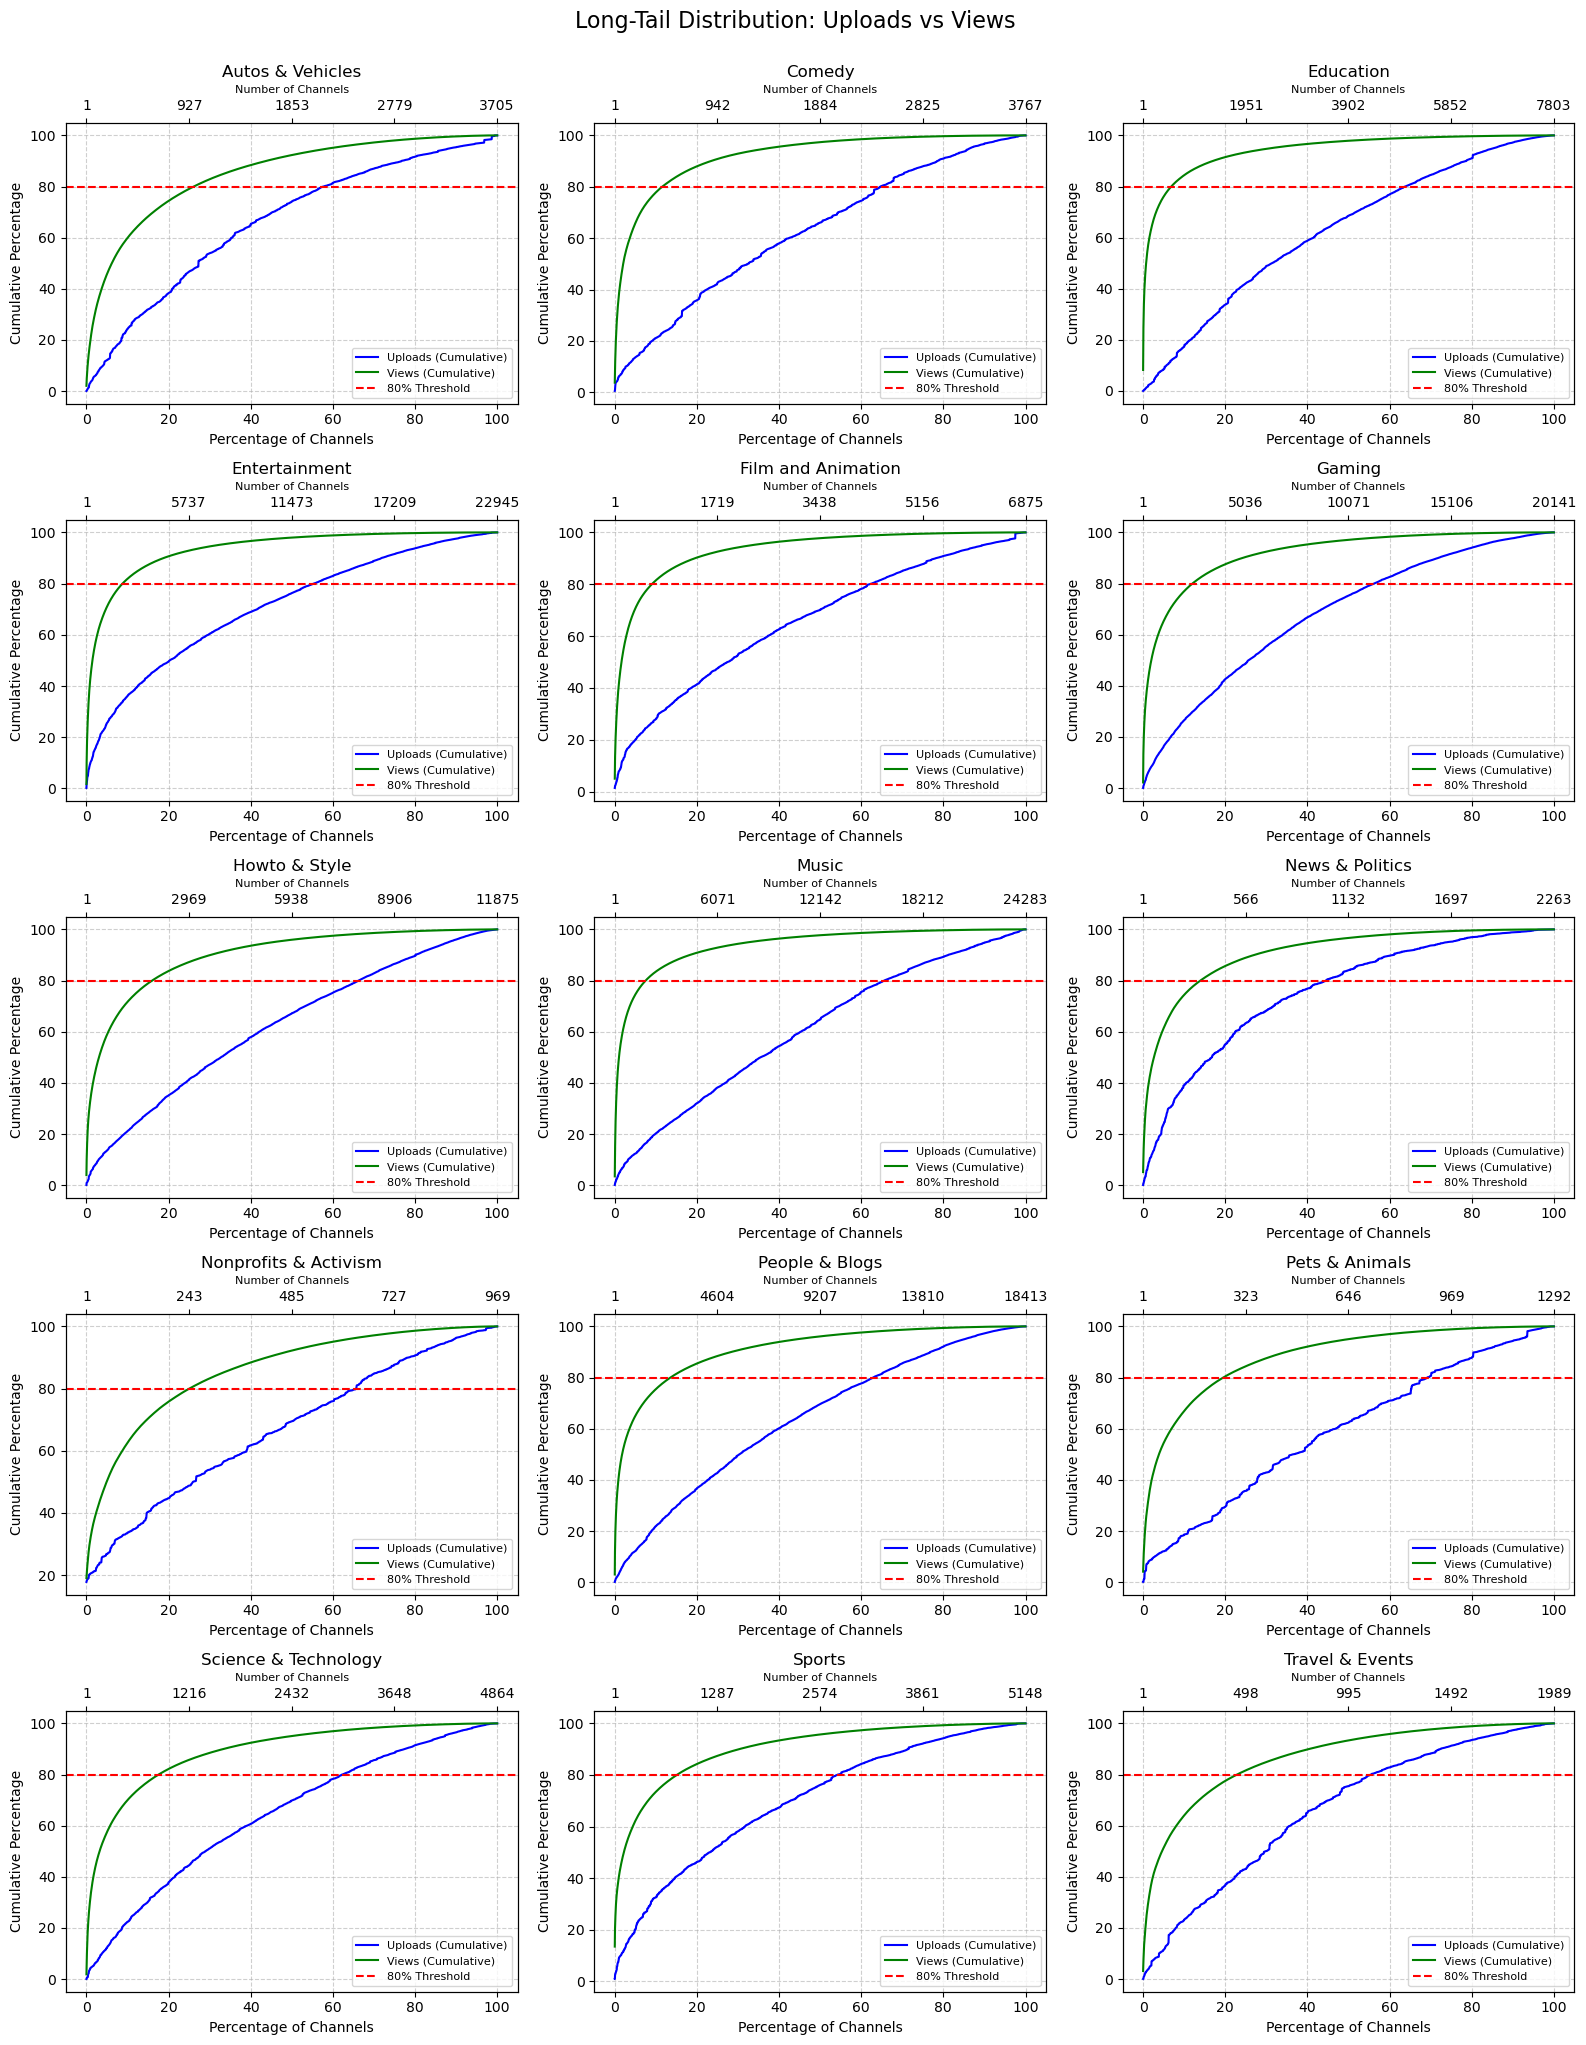

In [191]:
# Step 1: Aggregate data per channel
channel_contribution = channel_video_data.groupby(['channel_category', 'channel_id']).agg({
    'upload_date': 'count',    # Total uploads per channel
    'view_count': 'sum'        # Total views per channel
}).reset_index()

channel_contribution.rename(columns={
    'upload_date': 'total_uploads',
    'view_count': 'total_views'
}, inplace=True)

# Step 2: Normalize within each category
channel_contribution['upload_percentage'] = channel_contribution.groupby('channel_category')['total_uploads'].transform(lambda x: x / x.sum() * 100)
channel_contribution['view_percentage'] = channel_contribution.groupby('channel_category')['total_views'].transform(lambda x: x / x.sum() * 100)

import matplotlib.pyplot as plt
import numpy as np

# Assuming `channel_contribution` dataframe exists
categories = channel_contribution['channel_category'].unique()

# Calculate the number of rows needed for 2-column layout
n_cols = 3
n_rows = int(np.ceil(len(categories) / n_cols))

# Create a figure with subplots
fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(16, n_rows * 4),  # Adjust height dynamically
    sharex=False,
    sharey=False
)

# Flatten axes for easy indexing
axes = axes.flatten()

for i, category in enumerate(categories):
    # Filter and sort the subset
    subset = channel_contribution[channel_contribution['channel_category'] == category]
    subset = subset.sort_values(by='view_percentage', ascending=False).reset_index()

    # Calculate cumulative percentages
    cumulative_uploads = subset['upload_percentage'].cumsum()
    cumulative_views = subset['view_percentage'].cumsum()
    
    # Calculate x-axis values
    x_percentage = np.linspace(0, 100, len(subset))  # Percentage of channels
    x_channels = np.arange(1, len(subset) + 1)       # Absolute number of channels

    # Get the subplot axis
    ax = axes[i]

    # Plot uploads and views
    ax.plot(x_percentage, cumulative_uploads, label='Uploads (Cumulative)', color='blue')
    ax.plot(x_percentage, cumulative_views, label='Views (Cumulative)', color='green')
    
    # Add secondary x-axis for the number of channels
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())  # Match x-axis limits
    ax2.set_xticks(np.linspace(0, 100, 5))  # Match percentage scale for better alignment
    ax2.set_xticklabels(np.linspace(1, len(subset), 5, dtype=int))  # Actual channel numbers
    
    # Customize secondary x-axis
    ax2.set_xlabel("Number of Channels", fontsize=8)

    # Add titles and labels
    ax.set_title(f"{category}", fontsize=12)
    ax.set_xlabel("Percentage of Channels", fontsize=10)
    ax.set_ylabel("Cumulative Percentage", fontsize=10)
    ax.axhline(80, color='red', linestyle='--', label="80% Threshold")
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide unused subplots (if categories are fewer than the grid)
for j in range(len(categories), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Long-Tail Distribution: Uploads vs Views", fontsize=16, y=1.02)
plt.show()

In the plots above, we sorted the channels in descending order with respect to the number of views.

As we can see from the plots, we attain for almost every categories 80 % of the total views of the category with less than 20 % of the channels in this category. This means that a small amount of channels have an extremely high number of views that contribute to the success of their respective categories.

Whereas, the uploads cumulative curve being more gradual indicates that the channels that have the biggest impact on views are not necessarily the channels that have the highest upload frequency.

### Consistency Analysis

Consistency measures the regularity of video uploads within a channel category over a specific time period. It reflects how evenly spaced or predictable the uploads are across time, providing insight into the stability of content creation behavior.

High consistency indicates uploads occur at regular intervals. Low consistency indicates irregular or sporadic uploads.

Channels that upload consistently are often more professional, as they follow a predictable schedule. High consistency often correlates with better audience retention and channel growth.

## Step 3: Timeseries Analysis

## Step 4: Comparing the three Analysis

Add any comparative metrics or additional aggregations as needed.

## Step 5: Some ML Algorithms